In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 导入数据集
data = np.loadtxt('xor_dataset.csv', delimiter=',')
print('数据集大小：', len(data))
print(data[:5])

# 划分训练集与测试集
ratio = 0.8
split = int(ratio * len(data))
np.random.seed(0)
data = np.random.permutation(data)
# y的维度调整为(len(data), 1)，与后续模型匹配
x_train, y_train = data[:split, :2], data[:split, -1].reshape(-1, 1)
x_test, y_test = data[split:, :2], data[split:, -1].reshape(-1, 1)

数据集大小： 1000
[[ 1.7641  0.4002  0.    ]
 [ 0.9787  2.2409  0.    ]
 [ 1.8676 -0.9773  1.    ]
 [ 0.9501 -0.1514  1.    ]
 [-0.1032  0.4106  1.    ]]


In [3]:
# 基类
class Layer:
    
    # 前向传播函数，根据输入x计算该层的输出y
    def forward(self, x):
        raise NotImplementedError
    
    # 反向传播函数，输入上一层回传的梯度grad，输出当前层的梯度
    def backward(self, grad):
        raise NotImplementedError
    
    # 更新函数，用于更新当前层的参数
    def update(self, learning_rate):
        pass

In [4]:
class Linear(Layer):    

    def __init__(self, num_in, num_out, use_bias=True):
        self.num_in = num_in # 输入维度
        self.num_out = num_out # 输出维度
        self.use_bias = use_bias # 是否添加偏置

        # 参数的初始化非常重要
        # 如果把参数默认设置为0，会导致Wx=0，后续计算失去意义
        # 我们直接用正态分布来初始化参数
        self.W = np.random.normal(loc=0, scale=1.0, size=(num_in, num_out))
        if use_bias: # 初始化偏置
            self.b = np.zeros((1, num_out))
        
    def forward(self, x):
        # 前向传播y = Wx + b
        # x的维度为(batch_size, num_in)
        self.x = x
        self.y = x @ self.W # y的维度为(batch_size, num_out)
        if self.use_bias:
            self.y += self.b
        return self.y
    
    def backward(self, grad):
        # 反向传播，按照链式法则计算
        # grad的维度为(batch_size, num_out)
        # 梯度要对batch_size取平均
        # grad_W的维度与W相同，为(num_in, num_out)
        self.grad_W = self.x.T @ grad / grad.shape[0]
        if self.use_bias:
            # grad_b的维度与b相同，为(1, num_out)
            self.grad_b = np.mean(grad, axis=0, keepdims=True)
        # 向前传播的grad维度为(batch_size, num_in)
        grad = grad @ self.W.T
        return grad
    
    def update(self, learning_rate):
        # 更新参数以完成梯度下降
        self.W -= learning_rate * self.grad_W
        if self.use_bias:
            self.b -= learning_rate * self.grad_b

In [5]:
class Identity(Layer):
    # 单位函数

    def forward(self, x):
        return x

    def backward(self, grad):
        return grad


class Sigmoid(Layer):  
    # 逻辑斯谛函数

    def forward(self, x):
        self.x = x
        self.y = 1 / (1 + np.exp(-x))
        return self.y
    
    def backward(self, grad):
        return grad * self.y * (1 - self.y)


class Tanh(Layer):
    # tanh函数

    def forward(self, x):
        self.x = x
        self.y = np.tanh(x)
        return self.y

    def backward(self, grad):
        return grad * (1 - self.y ** 2)


class ReLU(Layer):
    # ReLU函数

    def forward(self, x):
        self.x = x
        self.y = np.maximum(x, 0)
        return self.y

    def backward(self, grad):
        return grad * (self.x >= 0)


    
# 存储所有激活函数和对应名称，方便索引
activation_dict = { 
    'identity': Identity,
    'sigmoid': Sigmoid,
    'tanh': Tanh,
    'relu': ReLU
}

In [6]:
class MLP:

    def __init__(
        self, 
        layer_sizes, # 包含每层大小的list
        use_bias=True, 
        activation='relu',
        out_activation='identity'
    ):
        self.layers = []
        num_in = layer_sizes[0]
        for num_out in layer_sizes[1: -1]:
            # 添加全连接层
            self.layers.append(Linear(num_in, num_out, use_bias)) 
            # 添加激活函数
            self.layers.append(activation_dict[activation]()) 
            num_in = num_out
        # 由于输出需要满足任务的一些要求
        # 例如二分类任务需要输出[0,1]之间的概率值
        # 因此最后一层通常做特殊处理
        self.layers.append(Linear(num_in, layer_sizes[-1], use_bias))
        self.layers.append(activation_dict[out_activation]())
        
    def forward(self, x):
        # 前向传播，将输入依次通过每一层
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, grad):
        # 反向传播，grad为损失函数对输出的梯度
        # 将该梯度依次回传，得到每一层参数的梯度
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
            
    def update(self, learning_rate):
        # 更新每一层的参数
        for layer in self.layers:
            layer.update(learning_rate)

测试精度： 0.97


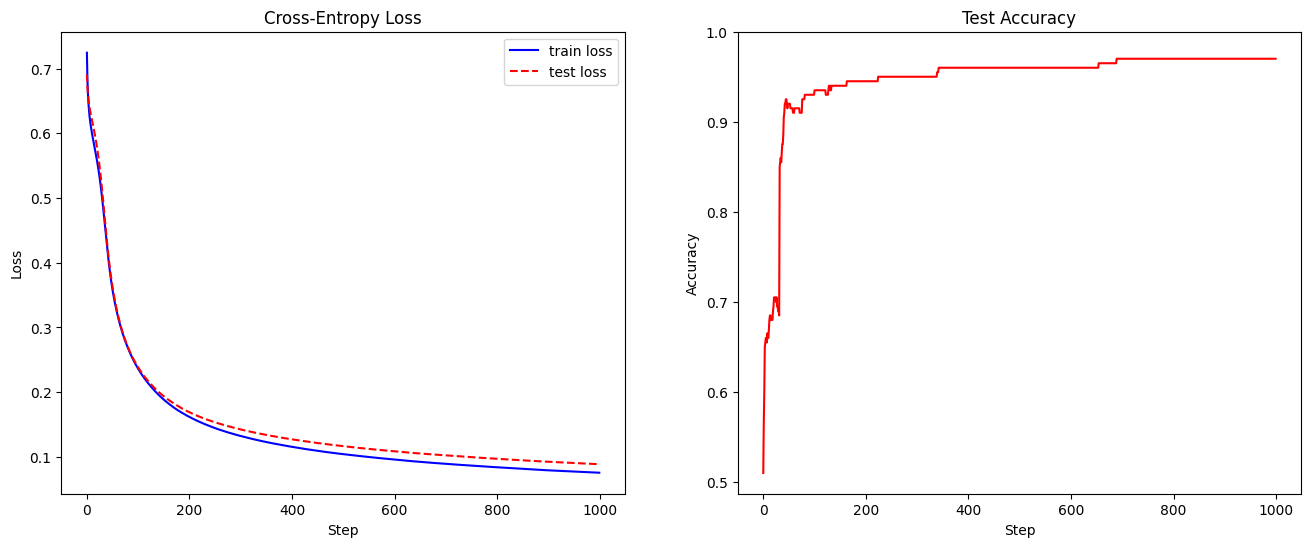

In [7]:
# 设置超参数
num_epochs = 1000
learning_rate = 0.1
batch_size = 128
eps=1e-7 # 用于防止除以0、log(0)等数学问题

# 创建一个层大小依次为[2, 4, 1]的多层感知机
# 对于二分类任务，我们用sigmoid作为输出层的激活函数，使其输出在[0,1]之间
mlp = MLP(layer_sizes=[2, 4, 1], use_bias=True, out_activation='sigmoid')

# 训练过程
losses = []
test_losses = []
test_accs = []
for epoch in range(num_epochs):
    # 我们实现的MLP支持批量输入，因此采用SGD算法
    st = 0
    loss = 0.0
    while True:
        ed = min(st + batch_size, len(x_train))
        if st >= ed:
            break
        # 取出batch
        x = x_train[st: ed]
        y = y_train[st: ed]
        # 计算MLP的预测
        y_pred = mlp.forward(x)
        # 计算梯度∂J/∂y
        grad = (y_pred - y) / (y_pred * (1 - y_pred) + eps)
        # 反向传播
        mlp.backward(grad)
        # 更新参数
        mlp.update(learning_rate)
        # 计算交叉熵损失
        train_loss = np.sum(-y * np.log(y_pred + eps) \
            - (1 - y) * np.log(1 - y_pred + eps))
        loss += train_loss
        st += batch_size

    losses.append(loss / len(x_train))
    # 计算测试集上的交叉熵和精度
    y_pred = mlp.forward(x_test)
    test_loss = np.sum(-y_test * np.log(y_pred + eps) \
        - (1 - y_test) * np.log(1 - y_pred + eps)) / len(x_test)
    test_acc = np.sum(np.round(y_pred) == y_test) / len(x_test)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
print('测试精度：', test_accs[-1])
# 将损失变化进行可视化
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(losses, color='blue', label='train loss')
plt.plot(test_losses, color='red', ls='--', label='test loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(test_accs, color='red')
plt.ylim(top=1.0)
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.show()

In [8]:
import torch # PyTorch库
import torch.nn as nn # PyTorch中与神经网络相关的工具
from torch.nn.init import normal_ # 正态分布初始化

torch_activation_dict = {
    'identity': lambda x: x,
    'sigmoid': torch.sigmoid,
    'tanh': torch.tanh,
    'relu': torch.relu
}

# 定义MLP类，基于PyTorch的自定义模块通常都继承nn.Module
# 继承后，只需要实现forward函数，进行前向传播
# 反向传播与梯度计算均由PyTorch自动完成
class MLP_torch(nn.Module):

    def __init__(
        self, 
        layer_sizes, # 包含每层大小的list
        use_bias=True, 
        activation='relu',
        out_activation='identity'
    ):
        super().__init__() # 初始化父类
        self.activation = torch_activation_dict[activation]
        self.out_activation = torch_activation_dict[out_activation]
        self.layers = nn.ModuleList() # ModuleList以列表方式存储PyTorch模块
        num_in = layer_sizes[0]
        for num_out in layer_sizes[1:]:
            # 创建全连接层
            self.layers.append(nn.Linear(num_in, num_out, bias=use_bias))
            # 正态分布初始化，采用与前面手动实现时相同的方式
            normal_(self.layers[-1].weight, std=1.0)
            # 偏置项为全0
            self.layers[-1].bias.data.fill_(0.0)
            num_in = num_out

    def forward(self, x):
        # 前向传播
        # PyTorch可以自行处理batch_size等维度问题
        # 我们只需要让输入依次通过每一层即可
        for i in range(len(self.layers) - 1):
            x = self.layers[i](x)
            x = self.activation(x)
        # 输出层
        x = self.layers[-1](x)
        x = self.out_activation(x)
        return x

测试精度： 0.965


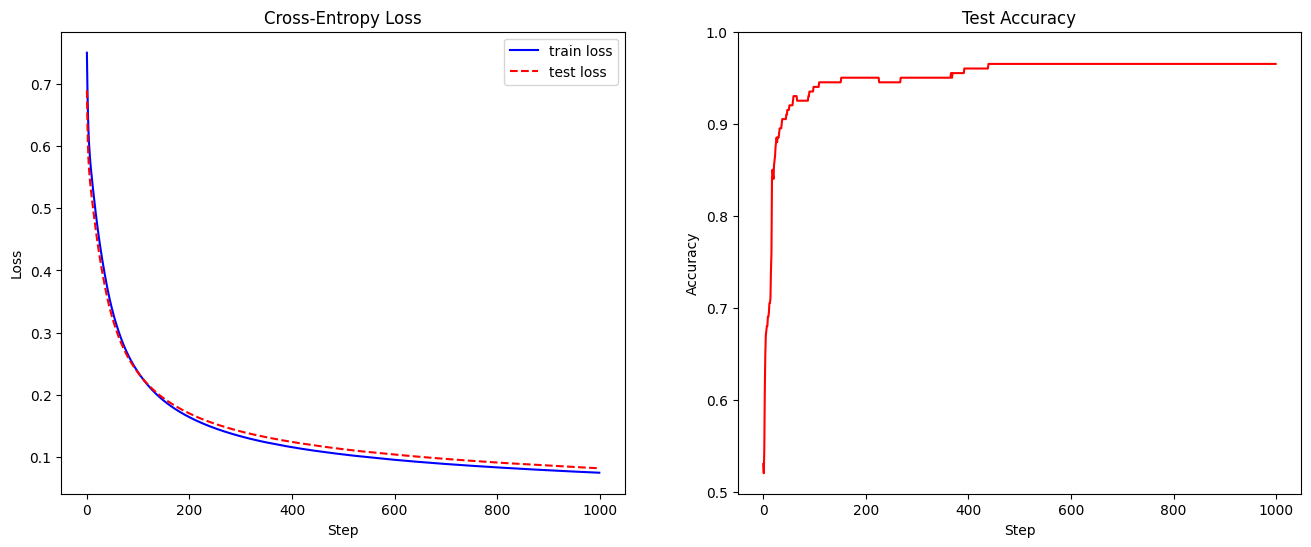

In [9]:
# 设置超参数
num_epochs = 1000
learning_rate = 0.1
batch_size = 128
eps = 1e-7
torch.manual_seed(0)

# 初始化MLP模型
mlp = MLP_torch(layer_sizes=[2, 4, 1], use_bias=True, 
    out_activation='sigmoid')

# 定义SGD优化器
opt = torch.optim.SGD(mlp.parameters(), lr=learning_rate)

# 训练过程
losses = []
test_losses = []
test_accs = []
for epoch in range(num_epochs):
    st = 0
    loss = []
    while True:
        ed = min(st + batch_size, len(x_train))
        if st >= ed:
            break
        # 取出batch，转为张量
        x = torch.tensor(x_train[st: ed], 
            dtype=torch.float32)
        y = torch.tensor(y_train[st: ed], 
            dtype=torch.float32).reshape(-1, 1)
        # 计算MLP的预测
        # 调用模型时，PyTorch会自动调用模型的forward方法
        # y_pred的维度为(batch_size, layer_sizes[-1])
        y_pred = mlp(x)
        # 计算交叉熵损失
        train_loss = torch.mean(-y * torch.log(y_pred + eps) \
            - (1 - y) * torch.log(1 - y_pred + eps))
        # 清空梯度
        opt.zero_grad()
        # 反向传播
        train_loss.backward()
        # 更新参数
        opt.step()

        # 记录累加损失，需要先将损失从张量转为numpy格式
        loss.append(train_loss.detach().numpy())
        st += batch_size

    losses.append(np.mean(loss))
    # 计算测试集上的交叉熵
    # 在不需要梯度的部分，可以用torch.inference_mode()加速计算
    with torch.inference_mode():
        x = torch.tensor(x_test, dtype=torch.float32)
        y = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
        y_pred = mlp(x)
        test_loss = torch.sum(-y * torch.log(y_pred + eps) \
            - (1 - y) * torch.log(1 - y_pred + eps)) / len(x_test)
        test_acc = torch.sum(torch.round(y_pred) == y) / len(x_test)
        test_losses.append(test_loss.detach().numpy())
        test_accs.append(test_acc.detach().numpy())

print('测试精度：', test_accs[-1])
# 将损失变化进行可视化
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(losses, color='blue', label='train loss')
plt.plot(test_losses, color='red', ls='--', label='test loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(test_accs, color='red')
plt.ylim(top=1.0)
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.show()